import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)# Analysis of time series and integration

In [176]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle, scipy

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
n_int_steps = 6
ocp = None

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 140

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = setup.ndays - 1

outdir = 'model_output/'
prefix = 'beta-analysis'


Loaded Italy Setup with 107 nodes.


In [141]:
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [1.3, .7, 1.2, 1], kind='linear')
course = course(np.arange(0, setup.ndays))

real_course = np.ones((setup.nnodes, setup.ndays)) * course
p = COVIDParametersOCP.OCParameters(setup=setup, M=M, when=when, posterior_draw = 64)
p.apply_epicourse(setup, real_course)

control_initial = np.zeros((M, N))

results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                              setup=setup,
                                                              parameters=p,
                                                              controls=control_initial,
                                                              save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc',
                                                              method='rk4',
                                                              n_rk4_steps=n_int_steps)
res = results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date')


  4%|▍         | 4/89 [00:00<00:04, 19.18it/s]

nnz before: 4088, after: 528
===> Integrating for model_output/beta-analysis-int-107_90-nc


100%|██████████| 89/89 [00:04<00:00, 20.55it/s]


<AxesSubplot:xlabel='date'>

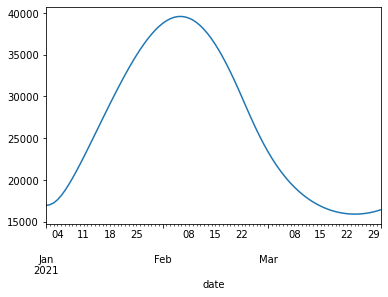

In [142]:
res.sum(axis=1).plot()

In [177]:

courses = {}
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [1.2,.55, 1.05, 1], kind='linear')
courses['U'] = course(np.arange(0, setup.ndays))
#course = scipy.interpolate.interp1d([0, 50, 100, 1000],[1, 1, 1, 1], kind='linear')# [.85, .85, .75, .85], kind='linear')  #([.75, .85, .75, .75])
#courses['C'] = course(np.arange(0, setup.ndays))
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [.65, .8, .35, .75], kind='linear')
courses['L'] = course(np.arange(0, setup.ndays))

cbs = ['U',  'L']
postdraws = [65]
all_res = {}
for cb in cbs:
    for postdraw in postdraws:
        real_course = np.ones((setup.nnodes, setup.ndays)) * courses[cb]
        p = COVIDParametersOCP.OCParameters(setup=setup, M=M, when=when, posterior_draw = postdraw)
        p.apply_epicourse(setup, real_course)
#    plt.figure()
#    plt.plot(real_course[0,:])

        control_initial = np.zeros((M, N))

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc',
                                                                      method='rk4',
                                                                      n_rk4_steps=n_int_steps)
        all_res[f'{postdraw}{cb}'] = results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date')
     

  1%|▏         | 2/139 [00:00<00:07, 19.12it/s]

nnz before: 4088, after: 528
===> Integrating for model_output/beta-analysis-int-107_140-nc


  2%|▏         | 3/139 [00:00<00:06, 19.58it/s]

nnz before: 4088, after: 528
===> Integrating for model_output/beta-analysis-int-107_140-nc


100%|██████████| 139/139 [00:06<00:00, 20.21it/s]


In [145]:
postdraws

[34, 96]

In [155]:
colors = {34:'r', 92:'b', 96:'g', 65:'orange'}

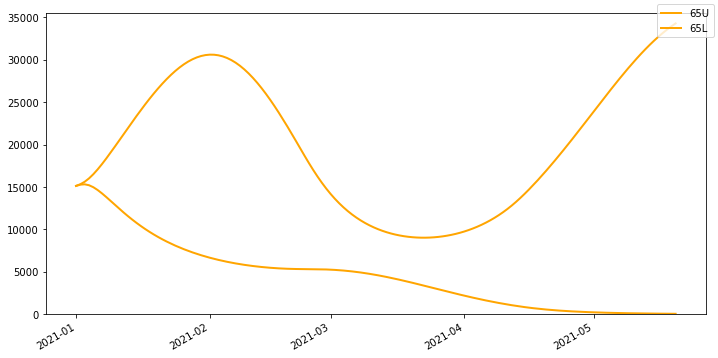

In [178]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

for cb in ['U','L']:#cbs):
    for postdraw in postdraws:
        ax.plot(all_res[f'{postdraw}{cb}'].sum(axis=1), linestyle='-', lw = 2, label = f'{postdraw}{cb}',c = colors[postdraw])

    ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

In [100]:
all_res[f'{postdraw}{cb}'].iloc[-1] - all_res[f'{postdraw}{cb}'].iloc[0]

place
Agrigento        -45.507052
Alessandria     -101.241676
Ancona           -96.133964
Aosta            -49.862451
Arezzo           -47.211243
                    ...    
Vercelli         -44.640999
Verona          -388.195790
Vibo Valentia     -8.389316
Vicenza         -313.112676
Viterbo          -81.254238
Length: 107, dtype: float64

IndexError: index 2 is out of bounds for axis 0 with size 2

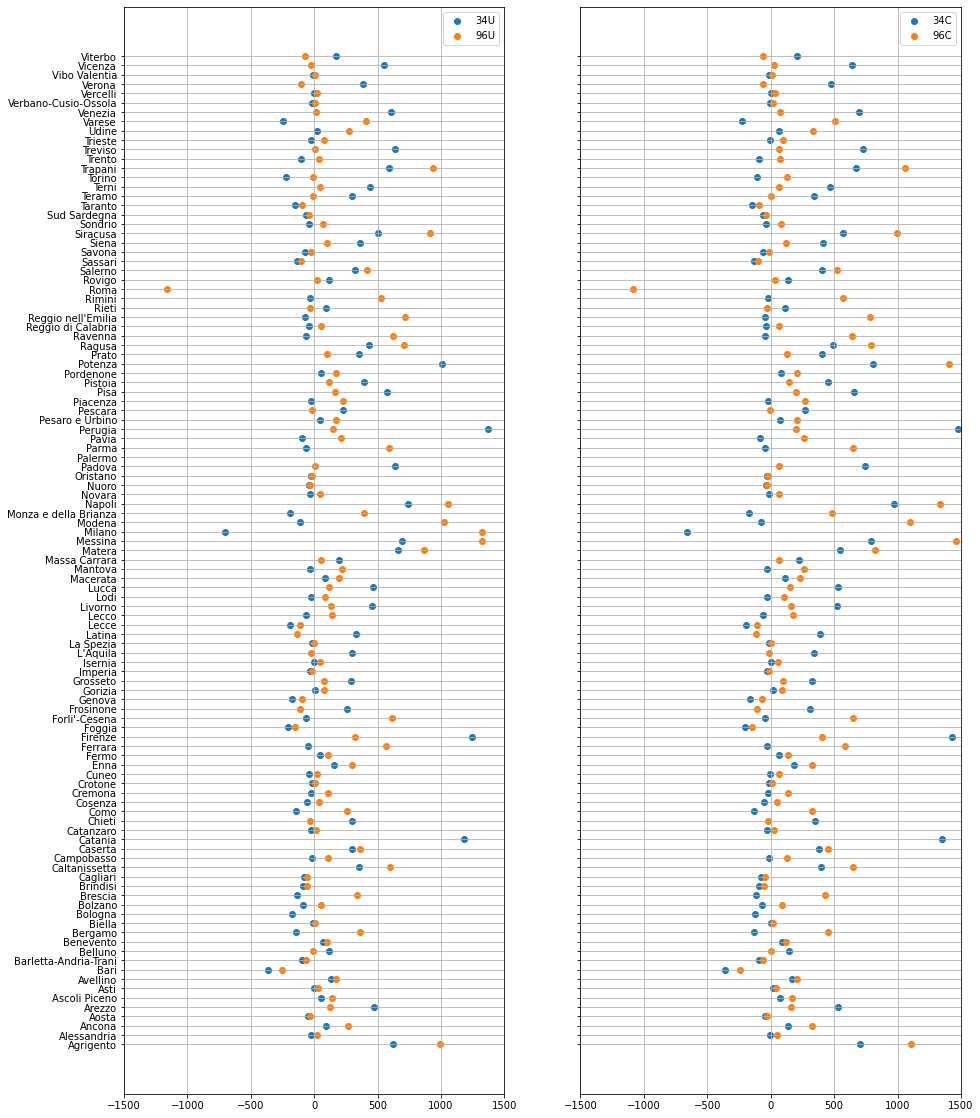

In [152]:
fig, axes = plt.subplots(1,2, figsize = (15,20), sharey=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

for i, cb in enumerate(['U','C','L']):#cbs):
    for j, postdraw in enumerate(postdraws):
        axes.flat[i].scatter(
                   all_res[f'{postdraw}{cb}'].iloc[-1] - all_res[f'{postdraw}{cb}'].iloc[0], 
            all_res[f'{postdraw}{cb}'].columns,
                marker = 'o',
                label = f'{postdraw}{cb}',
               #c = colors[postdraw],
                   #alpha = .5
                  )
        axes.flat[i].set_xlim(-1500,1500)
        axes.flat[i].legend()
        axes.flat[i].grid(True)

#plt.xticks( rotation='vertical')
#ax.set_yscale('log')
#fig.autofmt_xdate()
fig.legend();


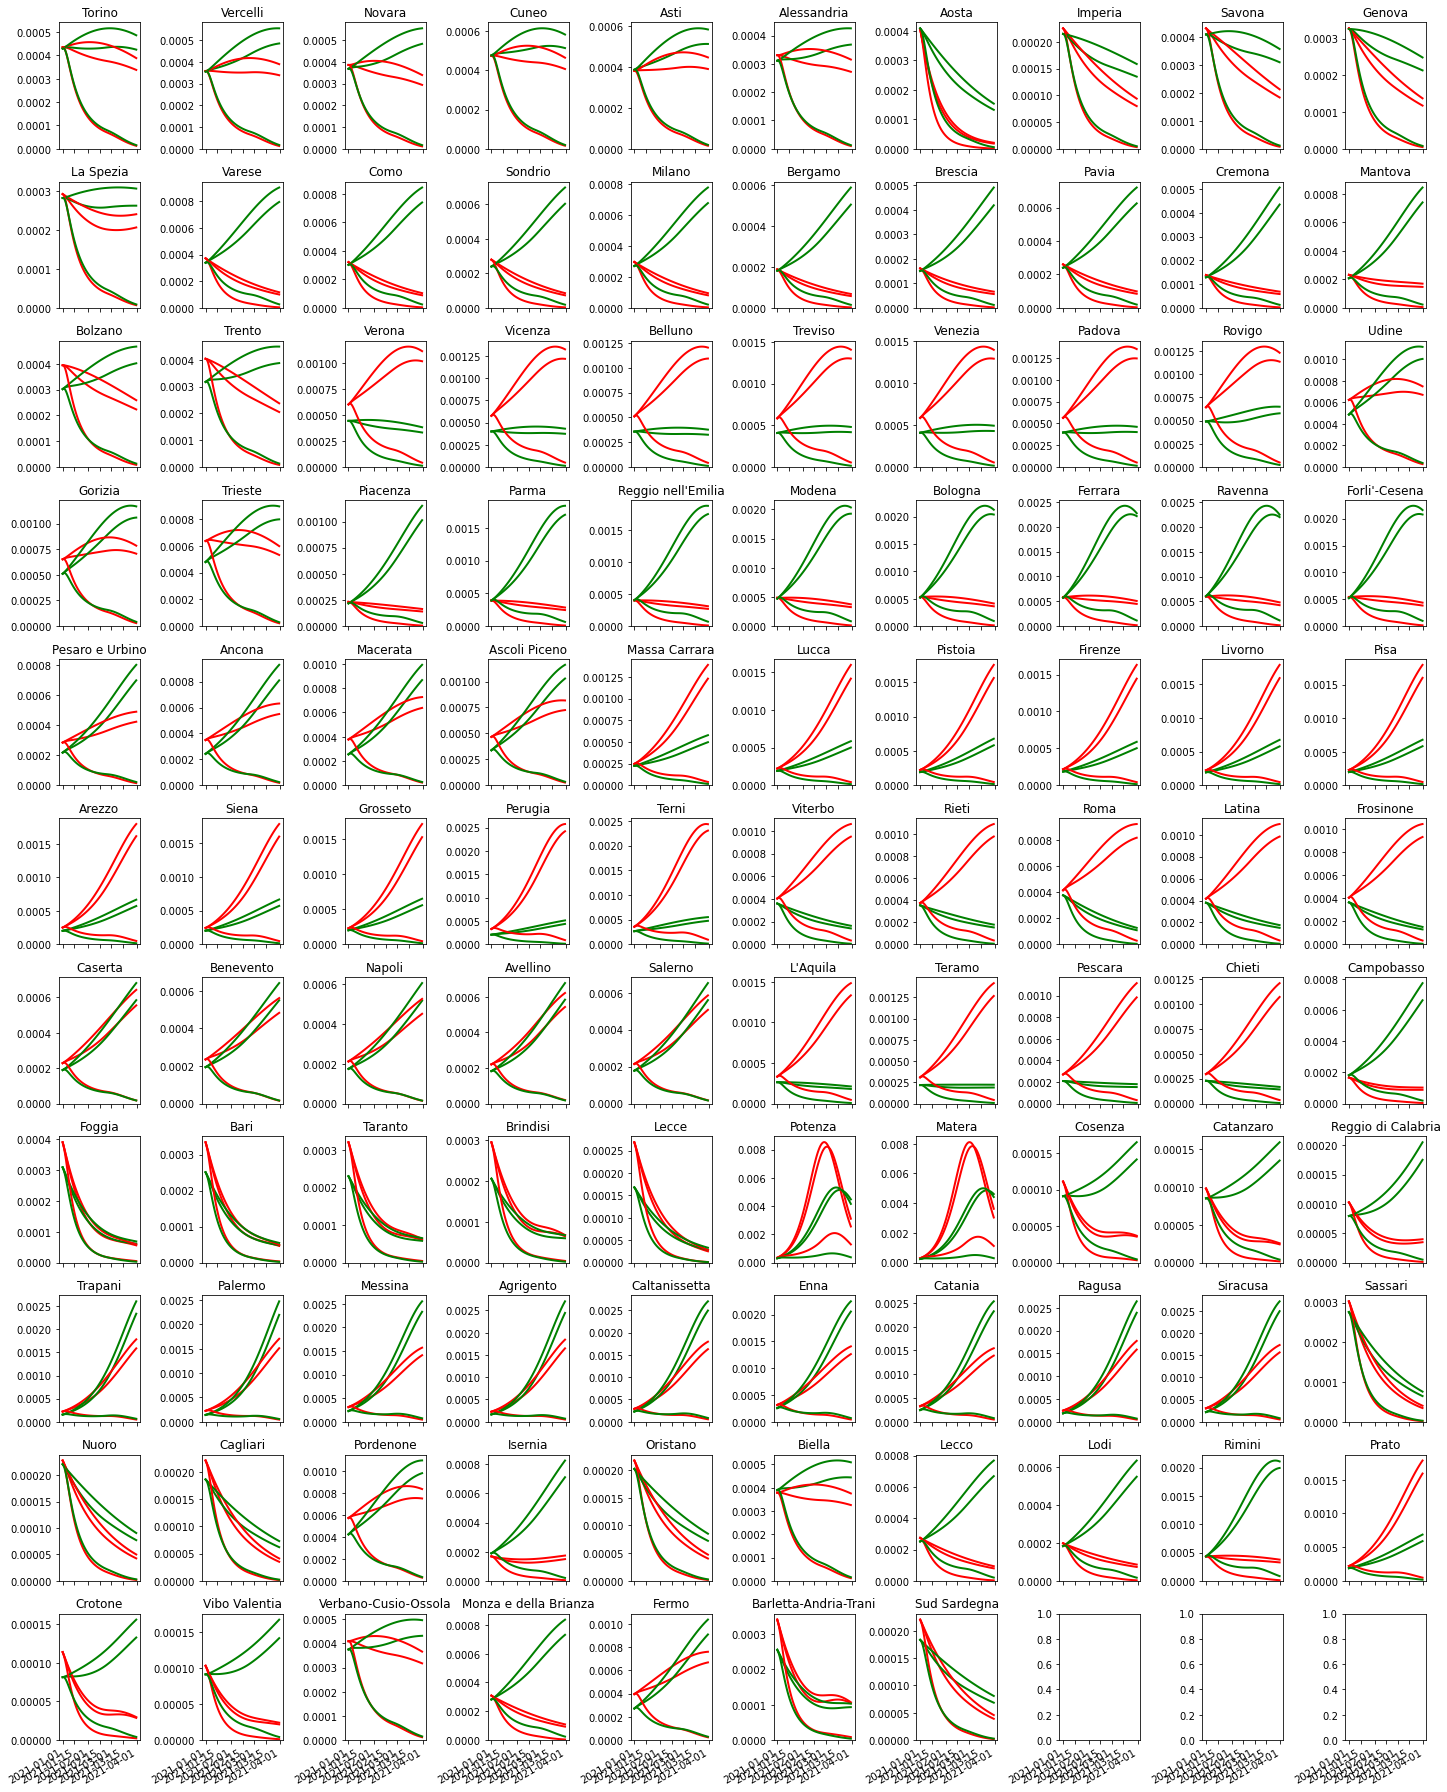

In [153]:
fig, axes = plt.subplots(11,10, figsize = (20,25), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns
for k, nname in enumerate(setup.ind2name):
    for cb in ['U','C','L']:#cbs):
        for postdraw in postdraws:
            axes.flat[k].plot(all_res[f'{postdraw}{cb}'][nname]/setup.pop_node[k], linestyle='-', lw = 2, c = colors[postdraw])
    #axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,3], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    axes.flat[k].set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()

# Compare scenarios

In [ ]:
scenarios = [ 'U', 'L'] # 'U', 'C' 
mydata = {}
for scn in scenarios:
    mydata[scn] = pd.read_csv(f'model_output/{scn}-r1-t75000-int107-120-nc.csv', index_col= 'date', parse_dates=True)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15,7), facecolor = 'white')
i = 3
st = states_names[i]
print(st)

for scn in scenarios:
    md = mydata[scn]
    axes.plot(md[(md['comp'] == st)].groupby('date').sum()['value'], linestyle='-', lw = 2, label = scn)
axes.set_title(st)
    
axes.legend()
fig.autofmt_xdate()

In [ ]:
md[(md['comp'] == st)].groupby('date').sum()['value']

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white')#, sharey=True)
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    for scn in scenarios:
        md = mydata[scn]
        axes.flat[k].plot(md[(md['comp'] == st) & (md['placeID'] == k)]['value'], linestyle='-', lw = 2, label = scn)
    axes.flat[k].set_title(nname)
    
axes.flat[0].legend()
fig.autofmt_xdate()

In [ ]:
import scipy
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [.75, .85, .45,.45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [.75, .85, .45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [1.3, .7, 2], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100, 100000], [1.3, .7, 2, 2], kind='linear')
course = course(np.arange(0,  250))
plt.plot(course)

# Comparisons with matlab integration

In [ ]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

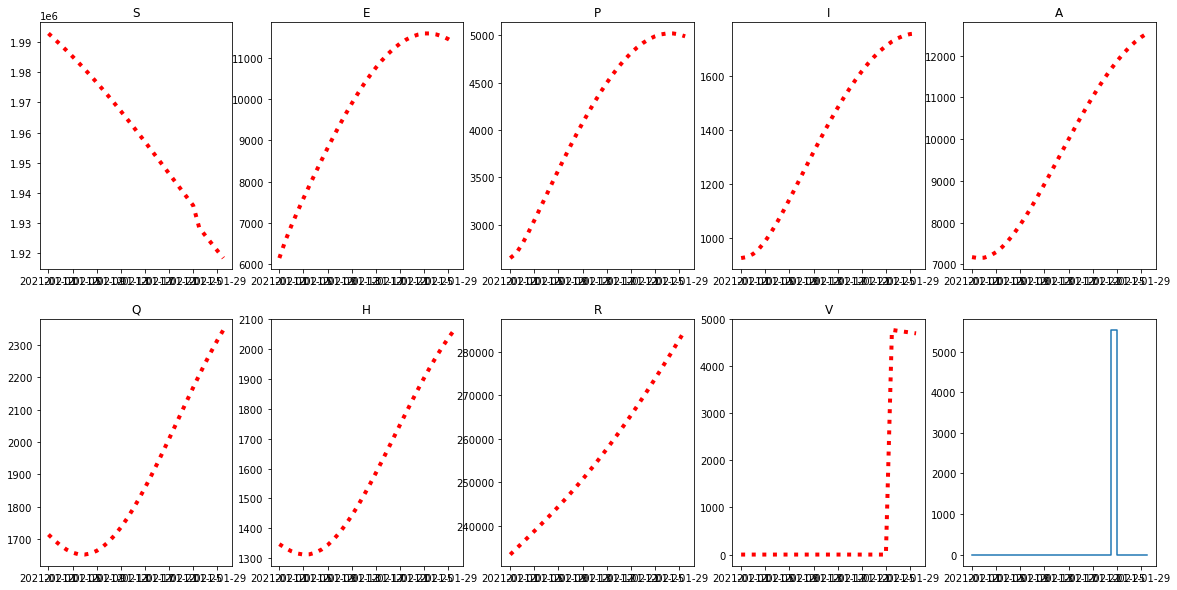

In [14]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

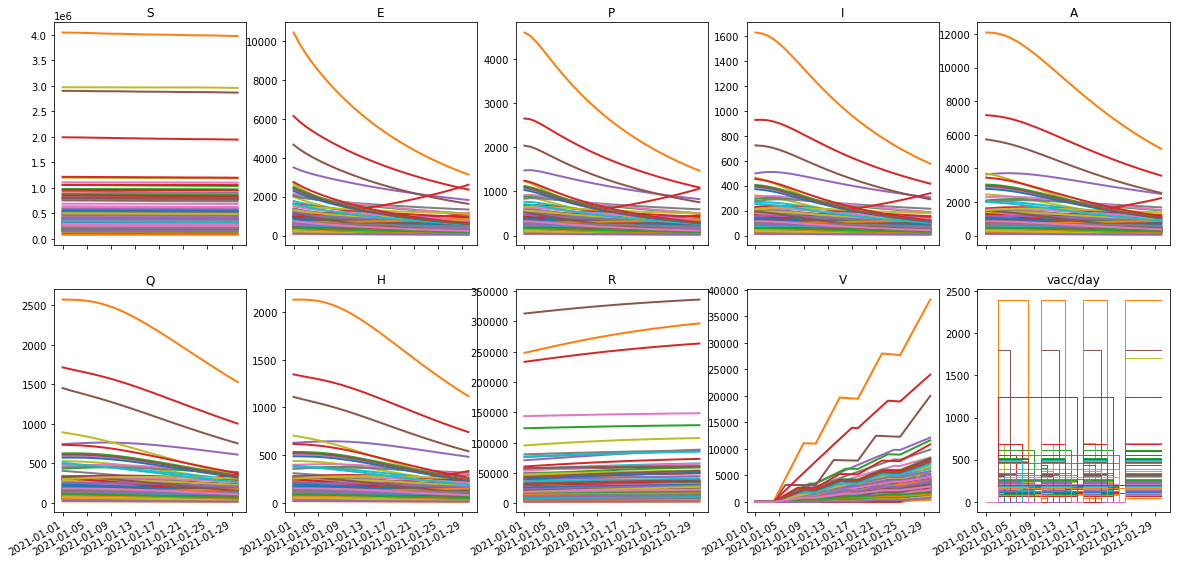

In [5]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

array([18717.01152605,  1415.76651468,  3056.84956554,  4863.35802919,
        1778.01254877,  3489.75552808,  1041.01209935,  1771.38559183,
        2286.79716835,  6968.07955543,  1818.76833399,  7378.86804915,
        4963.590753  ,  1500.17737879, 26924.49770441,  9233.00776585,
       10487.15936799,  4521.98690947,  2973.51558194,  3415.28509939,
        4400.13373862,  4482.30800476,  7674.84451378,  7144.02526236,
        1681.17614039,  7354.34830845,  7068.80930101,  7769.36148723,
        1946.17158129,  4380.33570474,  1154.74724794,  1942.44391801,
        2378.66335902,  3741.16570724,  4406.01516291,  5843.2364507 ,
        8404.63814752,  2863.59093359,  3226.16831553,  3268.9950248 ,
        2972.93572321,  3903.52615243,  2602.57166685,  1716.21617525,
        1614.32671219,  3213.08007556,  2422.73262271,  8377.30195012,
        2773.62999304,  3471.20004863,  2838.40849719,  2213.40362016,
        1835.91558509,  5437.25250076,  1869.05036983,  2626.18020098,
      

In [ ]:
len(setup.pop_node[mydata['placeID']])

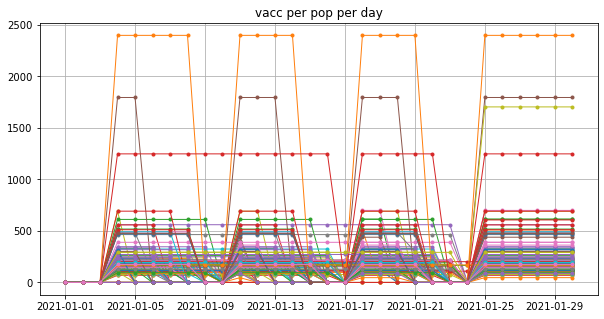

In [30]:
ndays

25

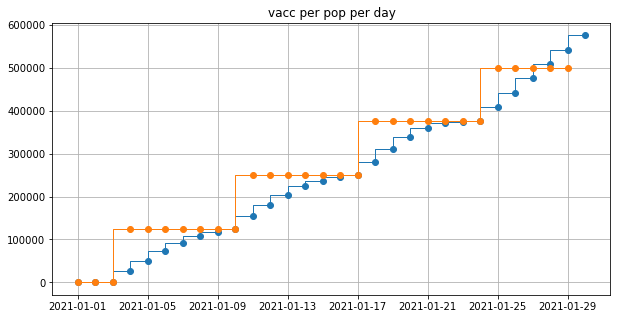

In [6]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1).cumsum(), lw = 1, ls = '-', marker='o')
ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index[:-1],  stockpile_national, lw = 1, ls = '-', marker='o')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()
#ax.set_ylim(0)

In [9]:
stockpile_national_constraint

array([    inf,     inf,     inf, 125000.,     inf,     inf,     inf,
           inf,     inf,     inf, 250000.,     inf,     inf,     inf,
           inf,     inf,     inf, 375000.,     inf,     inf,     inf,
           inf,     inf,     inf, 500000.,     inf,     inf,     inf,
           inf])

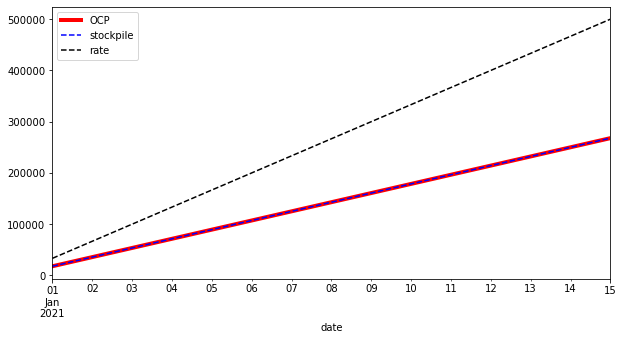

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum().plot(c = 'r', lw = 4, label = 'OCP')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*dosesperweek/7), c='b', ls='--', label='stockpile')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
ax.legend()
#ax.set_ylim(0,1e6)

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()